In [1]:
import numpy as np
from scipy import special
import netCDF4 as nc

In [2]:
coarsePath= '/glade/work/adac/microHH/coarseData/'
coarse_finest = nc.Dataset(coarsePath+'coarse4x1026_Re1800.nc', 'r')
#coarse = nc.Dataset(coarsePath+'coarse4x2052_Re1800.nc', 'r')
#coarse = nc.Dataset(coarsePath+'coarse4x40104_Re1800.nc', 'r')

In [3]:
kmax = 64
zsize = 18.074844397670482
dz = zsize / kmax
z = np.linspace(0.5*dz, zsize-0.5*dz, kmax)
# print(z)
# z_coarse=np.array(coarse_finest.variables["z"])
# #z_coarse=np.array(coarse.variables["z"])
# print(z_coarse)

In [4]:
def fix_bounds(u_string,coarse,itime,noslip=False,fix_bad_pad=False,nzbuffer=2):
    
    # leave out last point b/c it was bad padding from coarse graining
    # and ignored during training, but 
    # include sfc BC for interp, so shape stays the same    
    z_coarse = coarse.variables["z"]
    z_interp=np.zeros(z_coarse.shape)
    z_interp[1:]=z_coarse[:-1]
    
    u_coarse=np.array(np.mean(coarse.variables[u_string][:,:,:,itime],axis=(1,2)))
    u=np.zeros(u_coarse.shape[0])
    u[1:]=u_coarse[:-1]
    if not noslip:
        u[0]=2*u[1]-u[2] # extrap to surface, e.g. for b
    
    if fix_bad_pad:
        du=u[-nzbuffer-1]-u[-nzbuffer-2]
        for iz in range(-nzbuffer,0,1):
            u[iz]=u[-nzbuffer-1]+(nzbuffer+iz+1)*du

    return u,z_interp

In [5]:
itimeInit = 0
u_interp,z_interp = fix_bounds('u',coarse_finest,itimeInit,noslip=True,fix_bad_pad=True)
v_interp,_ = fix_bounds('v',coarse_finest,itimeInit,noslip=True,fix_bad_pad=False)
b_interp,_ = fix_bounds('b',coarse_finest,itimeInit,fix_bad_pad=False)

In [6]:
u = np.interp(z,z_interp,u_interp)
v = np.interp(z,z_interp,v_interp)
b = np.interp(z,z_interp,b_interp)
ug = np.zeros(kmax)
vg = np.zeros(kmax)
ug[:] = 0.049295030175465
vg[:] = 0.

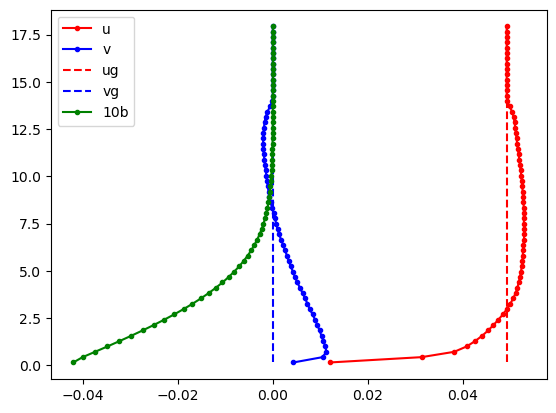

In [7]:
import matplotlib.pyplot as plt
plt.plot(u,z,'r.-',label='u')
plt.plot(v,z,'b.-',label='v')
plt.plot(ug,z,'r--',label='ug')
plt.plot(vg,z,'b--',label='vg')
plt.plot(10*b,z,'g.-',label='10b')
plt.legend()

In [8]:
float_type = 'f8'

nc_file = nc.Dataset("SBL1800_input.nc", mode="w", datamodel="NETCDF4", clobber=True)

nc_file.createDimension("z", kmax)
nc_z  = nc_file.createVariable("z" , float_type, ("z"))

nc_group_init = nc_file.createGroup("init");
nc_u = nc_group_init.createVariable("u", float_type, ("z"))
nc_v = nc_group_init.createVariable("v", float_type, ("z"))
nc_u_geo = nc_group_init.createVariable("u_geo", float_type, ("z"))
nc_v_geo = nc_group_init.createVariable("v_geo", float_type, ("z"))
nc_b = nc_group_init.createVariable("b", float_type, ("z"))

nc_z[:] = z[:]
nc_u[:] = u[:]
nc_v[:] = v[:]
nc_u_geo[:] = ug[:]
nc_v_geo[:] = vg[:]
nc_b[:] = b[:]

nc_file.close()